# Introduction to Data Mining - Term Project



*   Instructor: Prof. Songül Varlı
*   Data Set: First-order theorem proving [link](https://archive.ics.uci.edu/ml/datasets/First-order+theorem+proving)



In [12]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00249/ml-prove.tar.gz'
!tar -xvzf 'ml-prove.tar.gz'

--2021-01-09 20:26:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00249/ml-prove.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1152663 (1,1M) [application/x-httpd-php]
Saving to: ‘ml-prove.tar.gz’

ml-prove.tar.gz     100%[===================>]   1,10M   267KB/s    in 4,4s    

2021-01-09 20:26:58 (256 KB/s) - ‘ml-prove.tar.gz’ saved [1152663/1152663]

ml-prove/
ml-prove/all-data-raw.csv
ml-prove/test.csv
ml-prove/train.csv
ml-prove/validation.csv
ml-prove/all-data-raw-statistics.txt
ml-prove/all-data-statistics.txt
ml-prove/bridge-holden-paulson-details.txt


## About the Data Set

This data set created by James P. Bridge, et. al. They released a paper describing the data set and the problem that they try to solve [\[1\]](https://www.cl.cam.ac.uk/~sbh11/pdf/ml-prove-v3.pdf). Data set contains features of First Order Logic (FOC) theorems. FOC is based on quantifiers and variables related to these quantifiers. So, in contrast to propositional logic, which only use propositions that don't have any quantifiers or variables, FOC takes advantage of quantifiers, relations to create dynamic expressions [\[2\]](https://en.wikipedia.org/wiki/First-order_logic).

Data set is collected as follows: They used TPTP Library, which is a library of proof problems for automatic theorem provers [\[3\]](http://www.tptp.org/). They gave these problems that was taken from TPTP to an automatic theorem prover and obtained features of these theorems. At the end, they had 6118 problems. Their aim was to find a way to select the best heuristic to solve a proof problem.

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from imblearn.over_sampling import SMOTE

import xgboost as xgb

In [14]:
data_path = 'ml-prove/'

In [15]:
all_data = pd.read_csv(data_path + 'all-data-raw.csv', header = None)

In [16]:
all_data

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.833070,0.99682,0.833070,0.767890,0,0.769480,0.069952,0.16057,6,1.2734,...,0.736840,0.001880,0.738720,0.073308,0.18797,-100.00,-100.00,-100.0,-100.00,-100.00
1,0.833070,0.99682,0.833070,0.769480,0,0.771070,0.068363,0.16057,6,1.2734,...,0.742480,0.001880,0.744360,0.067669,0.18797,0.08,0.08,0.2,0.08,0.08
2,0.833070,0.99682,0.833070,0.767890,0,0.769480,0.069952,0.16057,6,1.2734,...,0.740600,0.001880,0.742480,0.069549,0.18797,-100.00,-100.00,-100.0,-100.00,-100.00
3,0.833070,0.99682,0.833070,0.767890,0,0.769480,0.069952,0.16057,6,1.2734,...,0.729320,0.001880,0.731200,0.080827,0.18797,-100.00,-100.00,-100.0,-100.00,-100.00
4,0.833070,0.99682,0.833070,0.767890,0,0.769480,0.069952,0.16057,6,1.2734,...,0.731200,0.001880,0.733080,0.078947,0.18797,-100.00,-100.00,-100.0,-100.00,-100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113,0.008403,0.77311,0.058824,0.008403,0,0.025210,0.042017,0.93277,8,3.1597,...,0.017544,0.017544,0.087719,0.008772,0.90351,-100.00,-100.00,-100.0,-100.00,-100.00
6114,0.017391,0.77391,0.052174,0.017391,0,0.043478,0.043478,0.91304,8,3.0783,...,0.018349,0.018349,0.091743,0.000000,0.90826,-100.00,-100.00,-100.0,-100.00,-100.00
6115,0.026786,0.79464,0.026786,0.017857,0,0.035714,0.044643,0.91964,8,3.0268,...,0.017391,0.017391,0.086957,0.000000,0.91304,-100.00,-100.00,-100.0,-100.00,-100.00
6116,0.017857,0.79464,0.017857,0.008929,0,0.026786,0.044643,0.92857,8,3.0357,...,0.017241,0.017241,0.086207,0.000000,0.91379,-100.00,-100.00,-100.0,-100.00,-100.00


## Features

Data set contains 58 columns. First 53 of them is actually explanatory features. Last 5 columns are related to class labels. They are the time that took to solve the problem for the corresponding heuristic. We will choose the fastest the as the best heuristic. If all columns are -100, then this means that no heuristic can solve the problem. We will have 5 columns for each heuristic. Its value will be zero 1 if it is the fastest, otherwise it will be 0. Two heuristics can both be fastest, that's why we need to do this way. So, we will have 5 different label features and we will need to build a 5 separate model for each of them.

In [16]:
classes =  ['class{}'.format(i + 1) for i in range(5)]

In [17]:
def determine_classes(data):
  class_data = np.zeros((data.shape[0], 5), dtype = 'int')

  for index, row in data.iterrows():
    class_info = row[53:58].values
    if np.all(class_info == -100):
      class_data[index] = np.zeros(5)
    else:
      class_info[class_info == -100] = 100
      min = np.min(class_info)
      labels = np.zeros_like(class_info)
      labels[class_info == min] = 1
      class_data[index] = labels
  
  return class_data

all_data = pd.concat([all_data, pd.DataFrame(determine_classes(all_data), columns = classes)], axis = 1)

Class distributions are given below

In [18]:
for cls in classes:
  print(all_data[cls].value_counts())

0    5029
1    1089
Name: class1, dtype: int64
0    5426
1     692
Name: class2, dtype: int64
0    5067
1    1051
Name: class3, dtype: int64
0    5008
1    1110
Name: class4, dtype: int64
0    4864
1    1254
Name: class5, dtype: int64


In [19]:
all_data = all_data.drop(columns=[53, 54, 55, 56, 57])

### Explanatory Features

As we discussed, first 53 columns are features that is to used to predict the class labels. These features are of two types: static features and dynamic features. First 14 features are static features. Static features mean that these features are obtained before attempting to solving the corresponding proof problem. And the 39 remaining features are dynamic features. Dynamic features are the features that are calculated after the automatic proof solver solved the problem. All features are numerical

**Static features (taken from the paper)**

1. Fraction of clauses that are unit clauses.
2. Fraction of clauses that are Horn clauses.
3. Fraction of clauses that are ground Clauses.
4. Fraction of clauses that are demodulators.
5. Fraction of clauses that are rewrite rules (oriented demodulators).
6. Fraction of clauses that are purely positive.
7. Fraction of clauses that are purely negative.
8. Fraction of clauses that are mixed positive and negative.
9. Maximum clause length.
10. Average clause length.
11. Maximum clause depth.
12. Average clause depth.
13. Maximum clause weight.
14. Average clause weight.


**Dynamic features (taken from the paper)**

1. Proportion of generated clauses kept. (Subsumed or trivial clauses are discarded.)
2. Sharing factor. (A measure of the number of shared terms.)
3. |P|/|P∪U|
4. |U|/|A|
5. Ratio of longest clause lengths in P and A.
6. Ratio of average clause lengths in P and A.
7. Ratio of longest clause lengths in U and A.
8. Ratio of average clause lengths in U and A.
9. Ratio of maximum clause depths in P and A.
10. Ratio of average clause depths in P and A.
11. Ratio of maximum clause depths in U and A.
12. Ratio of average clause depths in U and A.
13. Ratio of maximum clause standard weights in P and A.
14. Ratio of average clause standard weights in P and A.
15. Ratio of maximum clause standard weights in U and A.
16. Ratio of average clause standard weights in U and A.
17. Ratio of the number of trivial clauses to |P|.
18. Ratio of the number of forward subsumed clauses to |P|.
19. Ratio of the number of non-trivial clauses to |P|.
20. Ratio of the number of other redundant clauses to |P|.
21. Ratio of the number of non-redundant deleted clauses to |P|.
22. Ratio of the number of backward subsumed clauses to |P|.
23. Ratio of the number of backward rewritten clauses to |P|.
24. Ratio of the number of backward rewritten literal clauses to |P|.
25. Ratio of the number of generated clauses to |P|.
26. Ratio of the number of generated literal clauses to |P|.
27. Ratio of the number of generated non-trivial clauses to |P|.
28. context sr count/|P|.
29. Ratio of paramodulations to |P|.
30. factor count/|P|.
31. resolv count/|P|.
32. Fraction of unit clauses in U.
33. Fraction of Horn clauses in U.
34. Fraction of ground clauses in U.
35. Fraction of demodulator clauses in U.
36. Fraction of rewrite rule clauses in |U|.
37. Fraction of clauses with only positive literals in U.
38. Fraction of clauses with only negative literals in U.
39. Fraction of clauses with positive and negative literals in U

## Train Test Split

We will make a 85-15 train-test split

In [ ]:
df_train, df_test = train_test_split(all_data, test_size = 0.15)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
len(df_train), len(df_test)

(5200, 918)

## Data Normalization

Now, we normalize our features

In [ ]:
std_scaler = StandardScaler()

In [ ]:
train_normalized = std_scaler.fit_transform(df_train.drop(columns=classes))

In [ ]:
df_train_scaled = pd.DataFrame(train_normalized, index = df_train.index, columns = df_train.columns[:-5])
df_train_scaled[classes] = df_train[classes]
df_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,class1,class2,class3,class4,class5
0,-0.581176,-1.148278,-0.444473,-0.772657,0.0,-0.942584,0.162294,0.778799,-0.147416,0.162625,-0.504432,-0.824357,-0.455549,-0.221202,0.511194,-0.059262,0.309405,-0.157158,-0.335960,-0.407719,-0.289109,-0.145583,-0.522636,-0.084827,-0.473190,-0.437700,-0.099751,-0.224125,-0.120522,-0.199121,-0.440469,-0.365575,0.511194,0.644511,0.0,-0.239522,-0.027881,-0.080326,-0.243911,-0.175653,-0.242589,0.286639,-0.256844,0.163546,0.733962,-0.414878,-1.171432,-0.432628,-0.452757,-0.358337,-0.691993,0.866641,0.434823,0,0,0,0,1
1,-0.769323,-1.233454,-0.758257,-0.898360,0.0,0.294533,-0.364373,-0.120336,-0.147416,-0.060526,-0.773255,-0.803276,-0.484157,-0.259518,-0.741982,0.144088,-0.568381,-0.120911,0.587428,0.828676,0.233535,0.416383,0.035831,-0.034020,-0.473190,-0.472957,0.215808,0.824229,-0.102918,-0.033786,-0.440469,1.213322,-0.741982,-0.083866,0.0,-0.239522,-0.418662,-0.253105,-0.048945,0.505524,0.003689,-0.168517,-0.054185,1.442403,-0.102789,-0.577071,-2.355286,-0.457755,-0.555597,-0.487491,0.753836,-0.468856,-0.616302,0,1,0,0,0
2,-0.522608,0.399587,-0.516462,-0.408319,0.0,-0.497154,-0.622102,0.688310,-0.281079,-0.231717,2.318214,1.267446,2.123251,0.504065,0.661613,-0.126401,0.618495,-0.156589,0.587428,0.424271,0.964987,0.122376,0.035831,0.002443,-0.301494,0.164233,0.215808,0.292621,-0.090026,0.143319,-0.240701,-0.681355,0.661613,0.048567,0.0,-0.239522,-0.223271,-0.166715,-0.266171,-0.263177,-0.223026,-0.282306,-0.264281,-0.156168,0.025945,-0.577071,0.027990,-0.314671,-0.555597,-0.487491,-0.611561,-0.299709,0.704066,0,0,0,0,0
3,-1.158167,-3.282785,0.119234,-1.129274,0.0,-0.827658,-0.746252,1.032418,1.456549,1.475365,-0.773255,-1.092321,-0.243033,0.173371,-1.945085,0.189535,-1.336776,-0.157820,-1.721057,-1.529631,-0.289109,-0.350213,0.035831,-0.896364,-0.473190,-0.425605,-0.795411,-1.090456,-0.120522,-0.252050,4.553734,-0.428731,-1.945085,-0.083866,0.0,-0.239522,-0.418662,-0.253105,-0.415568,-0.657030,-0.369179,1.196919,-0.410708,-0.156168,-0.102789,-0.577071,-2.083783,0.088645,-0.555597,-0.487491,-0.620647,-0.404376,0.744585,0,0,0,0,0
4,-1.037255,-0.782594,-0.531120,-0.979139,0.0,-0.865782,0.238302,0.680345,0.654566,0.164648,-0.638843,-0.666726,-0.353378,-0.154062,0.761859,-0.172229,0.676123,-0.156694,0.587428,0.412369,-0.289109,0.134123,0.035831,-0.025269,0.003695,-0.057857,0.215808,0.267885,-0.096517,-0.094588,-0.440469,-0.681355,0.761859,0.181001,0.0,-0.239522,-0.418662,-0.253105,-0.253446,-0.083372,-0.226478,-0.054728,-0.266403,1.442403,0.347779,-0.430703,-1.232149,-0.507217,-0.456605,-0.363169,-0.283014,0.123171,0.247243,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,-0.495739,0.403758,-0.482397,-0.375989,0.0,-0.466906,-0.624934,0.662400,-0.281079,-0.237189,2.318214,1.246472,2.123251,0.491865,0.711736,-0.126481,0.621921,-0.156597,0.587428,0.424435,0.964987,0.122887,0.035831,0.002443,-0.301494,0.175042,0.215808,0.292621,-0.090026,0.145034,-0.340585,-0.681355,0.711736,0.048567,0.0,-0.239522,-0.223271,-0.166715,-0.266171,-0.263177,-0.223026,-0.282306,-0.264281,-0.156168,0.025945,-0.552873,0.035942,-0.316483,-0.531049,-0.456661,-0.588327,-0.301071,0.681153,0,0,0,0,0
5196,0.682723,0.306208,-0.794875,0.863720,0.0,1.012192,-0.447527,-0.729134,-0.548407,-0.459834,-0.370020,-0.423590,-0.337030,-0.263914,-2.245824,-0.193849,-1.507598,-0.072986,0.587428,-0.270945,-2.379280,-1.202100,0.035831,1.210122,0.957608,2.076318,0.215808,0.551397,-0.107047,0.024483,1.057841,2.160629,-2.245824,0.048567,0.0,-0.239522,-0.418662,-0.253105,0.405616,0.083115,0.458270,-0.282306,0.407396,0.163546,0.025945,2.423505,1.014159,-0.539307,2.488462,2.308035,2.269600,-0.468856,-2.138422,0

In [ ]:
test_normalized = std_scaler.transform(df_test.drop(columns=classes))
df_test_scaled = pd.DataFrame(test_normalized, index = df_test.index, columns = df_test.columns[:-5])
df_test_scaled[classes] = df_test[classes]
df_test_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,class1,class2,class3,class4,class5
0,0.963312,0.794003,-0.577876,0.974805,0.0,0.731089,0.045247,-0.671166,-0.548407,-0.494780,0.033215,1.489929,-0.500504,-0.170949,-0.792105,-0.222894,0.572550,-0.133572,0.587428,0.184324,-1.334179,-0.425460,0.035831,-0.020407,-0.473190,-0.038041,0.215808,-0.007515,-0.109851,-0.235875,-0.440469,1.276471,-0.792105,-0.083866,0.0,-0.239522,-0.418662,-0.253105,-0.218483,-0.376384,-0.160876,-0.282306,-0.213344,-0.156168,-0.102789,0.434003,1.014159,-0.196075,0.205418,0.468244,-0.061866,0.435730,-0.068638,0,0,0,0,0
1,-0.914396,-0.914761,2.720610,-1.135801,0.0,-1.045082,0.588009,0.703447,-0.414743,0.391845,-0.504432,-0.887603,-0.484157,0.019205,0.761859,3.328155,-1.080967,-0.157534,0.587428,-1.061146,1.278511,-0.403328,-0.522636,-0.551757,-0.473190,-0.512048,-0.278567,-0.668342,-0.120522,-0.280112,-0.440469,-0.681355,0.761859,-0.083866,0.0,1.054742,-0.418662,-0.253105,-0.336099,-0.367823,-0.296677,0.059061,-0.331126,-0.156168,-0.102789,-0.577071,-0.441205,3.407842,-0.555597,-0.487491,-0.605511,0.654426,0.411660,0,0,0,0,0
2,0.230268,0.794003,-0.062484,0.288847,0.0,0.063424,-0.364373,0.086221,-0.548407,-0.405391,-0.638843,-0.421128,-0.557720,-0.423293,-0.441194,-0.232479,-0.367807,-0.128335,0.587428,-0.067789,0.755866,-0.309866,1.525151,0.735121,1.911521,0.676868,0.215808,0.343111,-0.094334,0.002851,1.357464,-0.302419,-0.441194,-0.017649,0.0,-0.239522,0.753682,0.265234,0.069728,0.116408,-0.025079,-0.282306,0.064656,-0.156168,0.154679,0.127134,1.014159,-0.156675,0.158813,0.409715,-0.109459,-0.468856,0.250614,0,0,0,0,1
3,-0.585462,0.388094,-0.529710,-0.470282,0.0,-0.567485,-0.645006,0.760159,-0.281079,-0.199806,2.318214,1.031266,2.123251,0.335399,0.761859,-0.198690,0.159438,-0.156594,0.587428,0.131356,-0.289109,-0.249941,-1.215135,-0.928063,-0.473190,-0.435899,-0.943567,-0.770744,-0.120522,-0.272707,-0.440469,-0.681355,0.761859,0.048567,0.0,-0.239522,-0.418662,-0.253105,-0.251327,-0.274592,-0.208067,-0.282306,-0.248356,-0.156168,0.025945,-0.476492,0.374167,-0.230593,-0.453560,-0.359346,-0.491695,-0.236398,0.564684,0,0,0,0,0
4,2.029532,0.794003,-0.990182,1.396918,0.0,1.141945,1.917820,-1.772792,-0.815734,-0.750257,-0.504432,0.266865,-0.561807,-0.365062,-1.945085,-0.117918,-1.745681,2.959432,0.587428,0.457149,-0.289109,-0.543096,1.152765,2.522817,1.673007,2.492448,1.157469,2.568441,0.236119,0.823990,2.156556,1.087023,-1.945085,-0.083866,0.0,-0.239522,-0.418662,-0.253105,3.554751,2.905772,3.910814,-0.282306,3.565235,-0.156168,-0.102789,2.423505,1.014159,-0.430390,2.488462,1.820610,2.269600,-0.468856,-2.138422,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.569404,-0.074907,-0.371704,-0.581784,0.0,-0.783988,-0.013234,0.705892,-0.147416,0.226861,-0.504432,-0.418025,-0.480070,-0.082991,-0.240702,-0.262055,2.012798,-0.158031,-0.797668,-1.122727,-1.334179,-1.004637,0.594298,0.987937,-0.115490,0.783409,0.004797,-0.535111,-0.134573,-0.298977,0.658246,-0.112952,-0.240702,-0.083866,0.0,-0.239522,-0.027881,-0.080326,-0.308550,-0.476275,-0.270207,-0.054728,-0.308843,-0.156168,-0.102789,-0.577071,-0.015409,0.447480,-0.555597,-0.487491,0.024491,0.109076,-0.057306,1,0,1,1,1
914,0.430186,0.794003,0.865214,0.763729,0.0,0.525642,3.322292,-1.772792,-0.682070,-0.520346,-0.370020,1.337006,-0.467810,0.159017,-1.143017,0.119224,-1.667996,1.044668,0.587428,-0.551135,-1.856729,-1.110561,3.610019,4.032902,4.677683,5.402780,4.092203,2.093056,5.701697,4.130530,3.355145,-0.681355,-1.143017,-0.083866,0.0,-0.239522,6.615475,2.856966,3.076829,2.476675,2.953321,-0.282306,3.048504,-0.156168,-0.102789,2.423505,1.014159,-0.539307,2.488462,3.335451,2.269600,-0.468856,-2.138422,0,0,0,0,0
915,1.485

## Outlier Analysis

In this section, we will analyze our normalized data to see if there are any outliers. First, let us draw boxplot for every feature

In [ ]:
def draw_boxplots(data):
  fig, axes = plt.subplots(nrows=14, ncols=4)
  fig.set_figheight(25)
  fig.set_figwidth(25)
  fig.tight_layout(pad=3.0)
  for j, chunk in enumerate(np.array_split(data.columns[:-5], 14)):
    for i, feature in enumerate(chunk):
      sns.boxplot(x = data[feature], ax=axes[j, i])

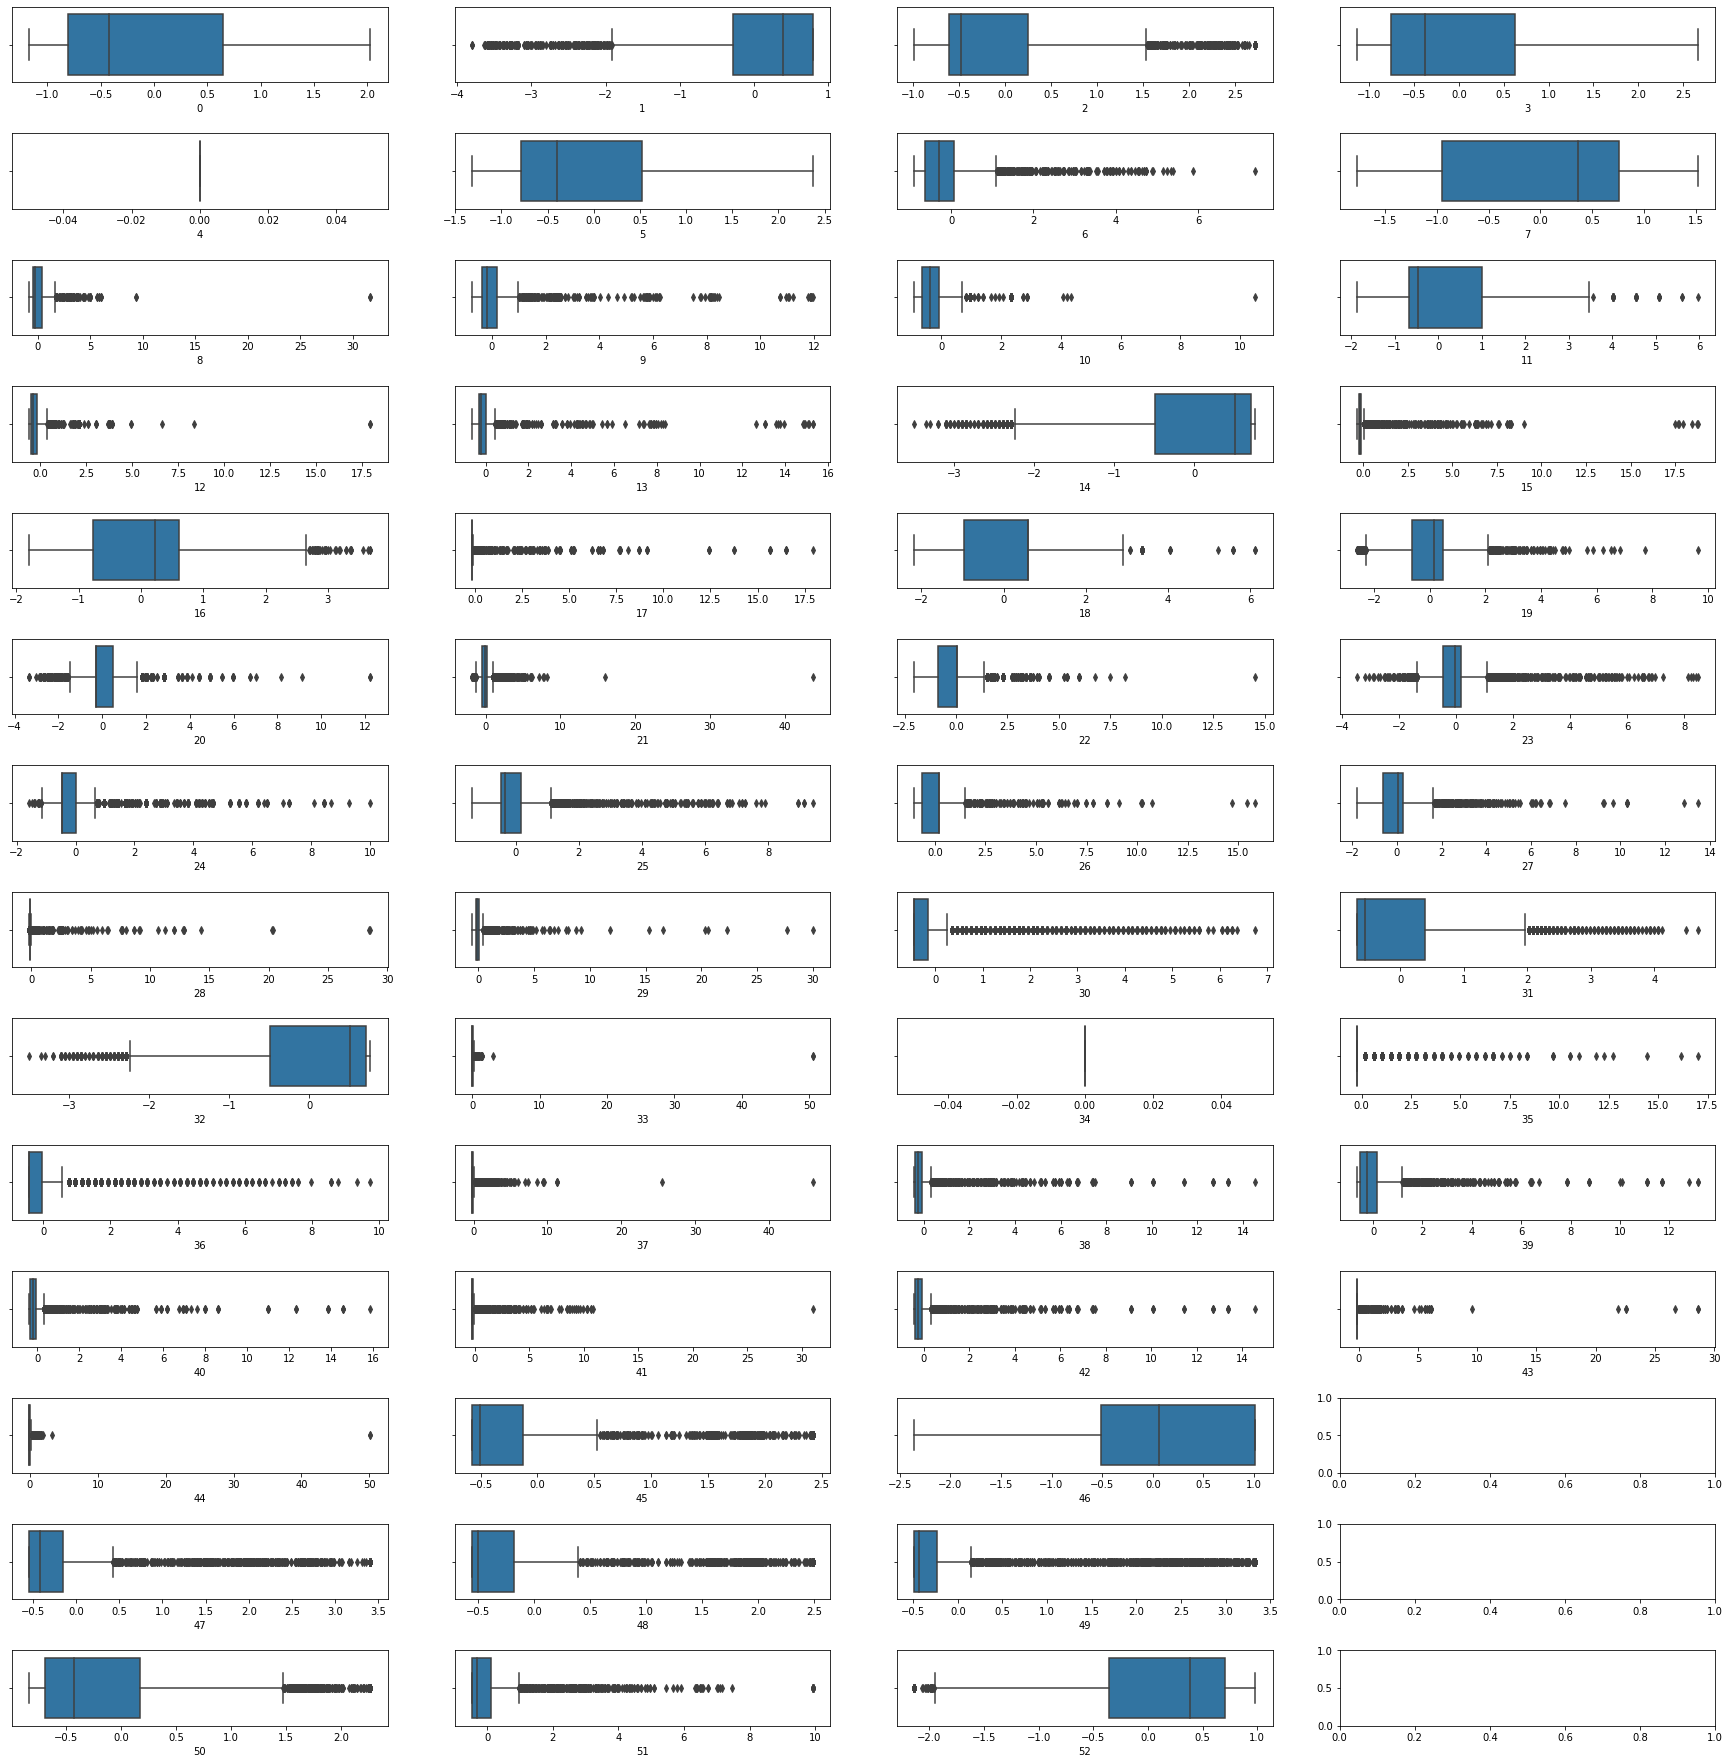

In [ ]:
draw_boxplots(df_train_scaled)

As you can see in the plots, there are lots of outlier values for some features. Removing them would be infeasible because we would lose a big portion of our data. So, we need a method to replace these outliers. We will replace the outliers in a way that the most negative value is $Q_1 - 1.5IQR$, and the most positive value is $Q_3 + 1.5IQR$ where $IQR = Q_3 - Q_1$

In [ ]:
def replace_outliers(data, method = 'mean'):
  q1 = data.quantile(0.25)
  q3 = data.quantile(0.75)
  iqr = q3 - q1

  lower_limit = q1 - 1.5 * iqr
  upper_limit = q3 + 1.5 * iqr

  below_outlier = (data < lower_limit)
  above_outlier = (data > upper_limit)

  outlier_removed = data.copy()
  outlier_removed[below_outlier] = lower_limit
  outlier_removed[above_outlier] = upper_limit


  return outlier_removed

In [ ]:
df_train_scaled = df_train_scaled.apply(lambda column: column if 'class' in str(column.name) else replace_outliers(column))

## Feature Analysis & Selection & Reduction

Having done the analysis of outliers, we now begin analyzing the features. Number of features in our data set is quite high with respect to the number of observations. We will first remove the features that has variance close to zero. Then, we will remove the highly correlated features since they are redundant. If two features are highly correlated, then we will keep the one that is most correlated with the output variable (class).

Let us first observe the variances of our features. We have two features that has zero variance. And one feature that has almost zero variance.

In [ ]:
df_train_scaled.var()

0         1.000192e+00
1         6.416220e-01
2         6.214919e-01
3         1.000192e+00
4         0.000000e+00
5         1.000192e+00
6         3.529180e-01
7         1.000192e+00
8         3.006460e-01
9         1.881750e-01
10        2.536098e-01
11        9.496359e-01
12        9.614295e-02
13        8.035288e-02
14        9.411982e-01
15        8.041777e-03
16        9.830640e-01
17        2.466344e-04
18        9.544295e-01
19        7.904743e-01
20        5.195726e-01
21        2.312047e-01
22        5.879668e-01
23        3.455234e-01
24        2.097688e-01
25        2.727421e-01
26        3.861710e-01
27        4.680381e-01
28        8.598733e-04
29        4.205431e-02
30        7.875302e-02
31        8.049924e-01
32        9.411982e-01
33        7.874704e-03
34        0.000000e+00
35        1.665017e-29
36        1.048073e-01
37        2.314392e-02
38        5.836069e-02
39        2.479497e-01
40        4.339645e-02
41        1.370791e-02
42        5.803580e-02
43        7

In [ ]:
var_thresh = VarianceThreshold(threshold=1e-5)
var_thresh.fit(df_train_scaled)
selected_feat_mask = var_thresh.get_support()
df_train_scaled = df_train_scaled.loc[:, selected_feat_mask]

In [ ]:
df_train_scaled.shape

(5200, 54)

In [ ]:
df_test_scaled = df_test_scaled.loc[:, selected_feat_mask]

In [ ]:
corr_matrix = df_train_scaled.corr()
corr_matrix

,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,class1,class2,class3,class4,class5
0,1.000000,0.614086,0.177575,0.945124,0.754305,0.391391,-0.828783,-0.522189,-0.759588,0.024894,0.460577,-0.333259,-0.338199,-0.666609,-0.375151,-0.347439,0.692775,0.296713,0.465479,-0.000362,0.002294,0.299106,0.156900,0.366191,0.406745,0.438569,0.411575,0.406593,0.311041,0.479948,0.541372,-0.666609,-0.287053,0.205410,0.202723,0.581157,0.370227,0.527823,-0.037736,0.584259,-0.272279,0.726894,0.537066,-0.170162,0.716365,0.579402,0.597070,-0.230146,-0.595440,0.000922,0.020181,0.053786,-0.054515,-0.042120
1,0.614086,1.000000,-0.138644,0.608535,0.241748,0.114850,-0.275717,-0.613797,-0.691628,0.316244,0.488955,0.027905,-0.087910,-0.400230,-0.428901,-0.229063,0.364204,0.308780,0.304928,0.189462,0.019406,0.057450,0.059574,0.096003,0.290700,0.282135,0.225299,0.333759,0.223720,0.310677,0.359541,-0.400230,-0.163078,0.054089,0.055881,0.259598,0.076018,0.216560,-0.259823,0.266747,-0.177830,0.422069,0.793703,-0.279787,0.429736,0.349838,0.144685,-0.233407,-0.143104,-0.007197,0.008933,-0.068951,0.016226,-0.048933
2,0.177575,-0.138644,1.000000,0.090266,0.314390,0.352014,-0.440812,0.239366,-0.054739,-0.268890,-0.092699,-0.126660,-0.170629,0.029816,0.176819,-0.059123,0.005664,-0.154101,0.032446,-0.171652,0.080997,0.090361,-0.193534,-0.018292,-0.158895,-0.023836,0.094061,-0.126972,0.106838,-0.005369,-0.078489,0.029816,-0.274368,0.019903,0.016062,-0.015274,0.069302,0.020453,0.153550,-0.017695,-0.257605,0.170132,-0.187677,0.685613,0.143862,-0.003277,0.267758,0.124462,-0.331019,0.067320,0.038521,0.115842,-0.012392,-0.050218
3,0.945124,0.608535,0.090266,1.000000,0.810922,0.178263,-0.782719,-0.487147,-0.733317,0.062933,0.407750,-0.277811,-0.332824,-0.613131,-0.467008,-0.312533,0.629888,0.237216,0.414287,-0.044746,-0.045695,0.233299,0.129440,0.317960,0.382260,0.325212,0.319393,0.312390,0.207645,0.473676,0.494185,-0.613131,-0.244820,0.211343,0.207527,0.531725,0.264454,0.464382,-0.068086,0.535318,-0.235751,0.717815,0.564467,-0.167401,0.721884,0.570081,0.596452,-0.242138,-0.579597,0.001156,-0.001719,0.038308,-0.054151,-0.037963
5,0.754305,0.241748,0.314390,0.810922,1.000000,0.069125,-0.920263,-0.276874,-0.684418,-0.044242,0.278918,-0.262411,-0.376327,-0.498809,-0.238128,-0.321411,0.602123,0.115711,0.427965,-0.232095,-0.048168,0.298706,0.073696,0.386909,0.280779,0.214196,0.334334,0.117174,0.152653,0.366260,0.403829,-0.498809,-0.240980,0.169347,0.162666,0.556002,0.340508,0.529345,0.131666,0.555723,-0.231106,0.603880,0.229536,0.057204,0.603305,0.478831,0.725465,-0.291244,-0.673538,0.009658,-0.002691,0.138262,-0.082804,-0.073414
6,0.391391,0.114850,0.352014,0.178263,0.069125,1.000000,-0.414564,-0.175604,-0.161952,-0.237957,0.157727,-0.378247,-0.169746,-0.397970,0.028340,-0.095756,0.408678,0.172720,0.137722,0.015066,0.094132,0.327057,0.103445,0.272598,0.207415,0.410433,0.271129,0.321479,0.284077,0.163332,0.349838,-0.397970,-0.249869,0.102445,0.104868,0.288382,0.316315,0.293348,0.096443,0.287494,-0.198054,0.248113,0.039370,-0.036384,0.204689,0.198911,0.187105,0.258880,-0.315500,0.071583,0.075913,0.055958,0.024580,0.012109
7,-0.828783,-0.275717,-0.440812,-0.782719,-0.920263,-0.414564,1.000000,0.319062,0.690209,0.104589,-0.347802,0.349681,0.365128,0.590787,0.174771,0.354731,-0.691291,-0.163361,-0.431165,0.221336,0.040229,-0.384175,-0.111368,-0.450373,-0.339968,-0.348754,-0.414623,-0.228251,-0.263372,-0.407903,-0.463024,0.590787,0.310430,-0.198233,-0.189886,-0.624008,-0.459254,-0.605620,-0.124421,-0.623289,0.289086,-0.656464,-0.227073,-0.047928,-0.636567,-0.519577,-0.749510,0.195335,0.751055,-0.014212,-0.029970,-0.149174,0.076436,0.071227
8,-0.522189,-0.613797,0.239366,-0.487147,-0.276874,-0.175604,0.319062,1.000000,0.720228,-0.273433,-0.521535,0.234719,0.101592,0.539406,0.241243,0.268446,-0.565173,-0.582562,-0.490117,-0.269381,0.021113,-0.310578,-0.210160,-0.341482,-0.476088,-0.528454,-0.46721

In [10]:
def filter_correlated_features(corr_matrix, threshold = 0.98):
  feats_to_keep = set(corr_matrix.columns[:-5])
  for i, feat_i in corr_matrix.iterrows():
    corr_i = corr_matrix.loc[i, classes].mean()

    for feat_j in feat_i.index:
       if i != feat_j and 'class' not in str(feat_j) and feat_i[feat_j] >= threshold:
        corr_j = corr_matrix.loc[feat_j, classes].mean()
        if corr_i > corr_j:
          feats_to_keep.discard(feat_j)
        else:
          feats_to_keep.discard(i)
          break # no need to look at feature i anymore, we discarded it
    
  feats_to_keep = list(feats_to_keep)
  feats_to_keep.sort()
  feats_to_keep += classes
  
  return feats_to_keep

In [ ]:
filtered_features = filter_correlated_features(corr_matrix)

In [ ]:
len(filtered_features)

50

In [ ]:
df_train_scaled = df_train_scaled[filtered_features]
df_test_scaled = df_test_scaled[filtered_features]

After removing the highly correlated features and constant features, we now have 45 features (+5 for class). Having done this, let us now reduce our features on the main data frames and rank our most important features for class variable.

### Ranking features with Random Forest

We will rank our using a random forest classifier. Random forest is actually a tree based algorithm. Random forest algorithm has three unique features that makes it a well-performing algorithm. First, it fits many decision trees at the same time and then averages the results obtained by each tree. This reduces the overfitting that results in only one decision tree. Second aspect is that it uses different subset of features for each tree. This prevents the model from being too dependent on few features rather than leveraging from every feature. One other thing that random forest do is resampling the training set for every tree that it builds. It uses different resampled version of the training set. Bootstrap resampling technique is used. Bootstrap is based on resampling with replacement. This means a resampled data set can have repeated rows. This also prevents overfitting because we use slightly different training set for every tree.


When we fit a random forest in scikit-learn, it calculates feature importances for every feature. Feature importance of a feature is calculated as the reduction in the entropy brought by that feature across the decision tree. In random forest, feature importances for every decision tree is averaged and in the end, an averaged importance score is obtained for each feature.

Note: Actually, scikit-learn uses gini index measure instead of entropy. We can change it but we will leave it that way. Entropy and gini are almost the same. Their behaviour is similar. They are both concave. Entropy ranges between 0 and 1. Gini ranges between 0 and 0.5. Gini is usually used because it does not compute logarithm like entropy do and logarithm computations are prone to be numerically unstable

gini(p) = $ p(1-p) $

entropy(p) = $- (plogp + (1-p)log(1-p))$

Now we will fit a random forest model for every class and average the results of feature importances

In [ ]:
feature_importances = np.zeros(len(df_train_scaled.columns[:-5]))
for cls in tqdm(classes):
  feature_ranker = RandomForestClassifier(n_estimators = 200, max_features = 20)
  feature_ranker.fit(df_train_scaled.drop(columns=classes), df_train_scaled[cls])
  feature_importances += feature_ranker.feature_importances_

feature_importances /= len(classes)










  0%|          | 0/5 [00:00<?, ?it/s]








 20%|██        | 1/5 [00:10<00:41, 10.41s/it]








 40%|████      | 2/5 [00:21<00:31, 10.53s/it]








 60%|██████    | 3/5 [00:30<00:20, 10.23s/it]








 80%|████████  | 4/5 [00:40<00:10, 10.13s/it]








100%|██████████| 5/5 [00:49<00:00,  9.94s/it]


Now we will take the feature importances and normalize them so that we can interpret them better

In [ ]:
normalized_importances = feature_importances / (feature_importances.sum()) * 100

In [ ]:
df_importances = pd.DataFrame({ 'features':  normalized_importances}, index = df_train_scaled.columns[:-5]).sort_values(by = 'features', ascending = False)

Let us visualize the feature importances

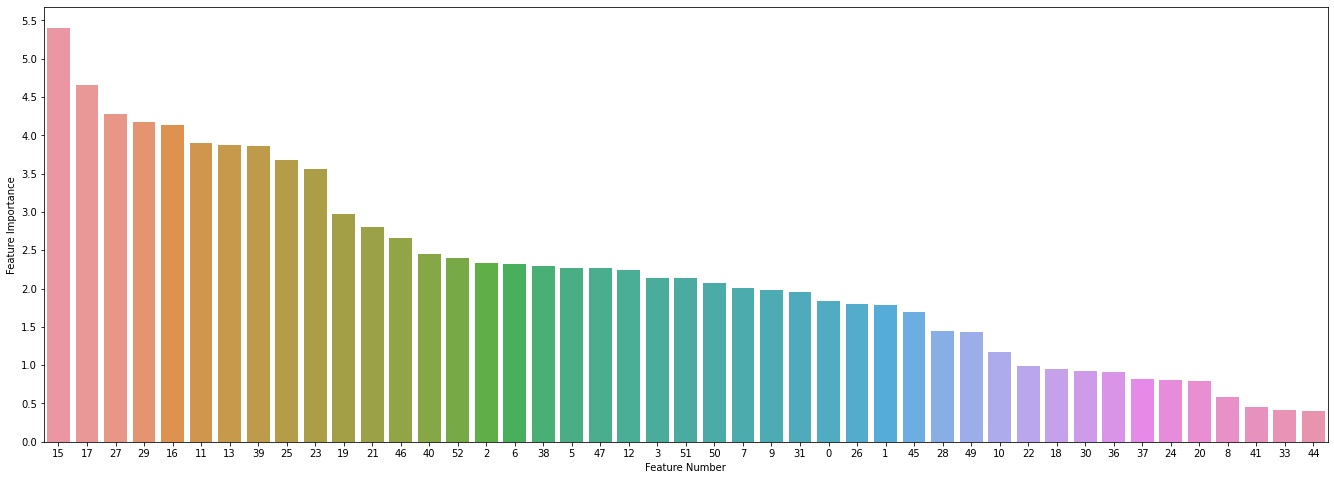

In [ ]:
figure, axes = plt.subplots(figsize=(23, 8))
axes.set_xlabel('Feature Number')
axes.set_ylabel('Feature Importance')
axes.set_yticks(np.arange(0, 6, 0.5))
sns.barplot(x=[str(i) for i in df_importances.index], y=df_importances.features.values)

We can see that the feature 15 and 17 is are far the most important features. After that 27, 29 and 16 are the second most important features. Also, we can see that last 3 features' importances are really low. They have almost no effect on entropy reduction. We can remove them to reduce the complexity of our models that we will build later.

In [ ]:
filtered_features = list(df_importances.features[df_importances.features > 0.7].index) + classes
len(filtered_features)

46

In [ ]:
df_train_scaled = df_train_scaled[filtered_features]
df_test_scaled = df_test_scaled[filtered_features]

We reduced our features to 41. Still, we have lot of features in our hands. But, removing features further will result in bad model performance. We can now use feature composition techniques like PCA to reduce our data dimension while preserving the information in our data.

### Dimensionality Reduction with PCA

We will reduce our feature dimension with Principal Component Analysis algorithm. We reduce the dimensionality of our data to a number of components such that the %98 of the variance of our original data is explained by this reduced data.

In [ ]:
def tune_pca(data, min_comp = 5, explained_variance_wanted = 0.98):
  candidates = np.arange(min_comp, data.shape[1] + 1, 1)
  best = 0
  best_exp_var = 0
  best_pca = None
  for i, cnd in enumerate(candidates):
    pca = PCA(n_components = cnd)
    pca.fit(data)
    explained_variance = pca.explained_variance_ratio_.sum()
    if best_exp_var < explained_variance and np.abs(explained_variance_wanted - explained_variance) <= 1e-3:
      best = cnd
      best_exp_var = explained_variance
      best_pca = pca
    print('Explained variance for %d number of components: %.3f' % (cnd, explained_variance))
  
  return best, best_pca


In [ ]:
n_components, pca = tune_pca(df_train_scaled.drop(columns = classes))

Explained variance for 5 number of components: 0.774
Explained variance for 6 number of components: 0.812
Explained variance for 7 number of components: 0.847
Explained variance for 8 number of components: 0.877
Explained variance for 9 number of components: 0.898
Explained variance for 10 number of components: 0.913
Explained variance for 11 number of components: 0.926
Explained variance for 12 number of components: 0.937
Explained variance for 13 number of components: 0.946
Explained variance for 14 number of components: 0.954
Explained variance for 15 number of components: 0.960
Explained variance for 16 number of components: 0.966
Explained variance for 17 number of components: 0.971
Explained variance for 18 number of components: 0.976
Explained variance for 19 number of components: 0.979
Explained variance for 20 number of components: 0.982
Explained variance for 21 number of components: 0.985
Explained variance for 22 number of components: 0.987
Explained variance for 23 number 

In [ ]:
n_components

19

We will reduce our features to 19.

In [ ]:
train_reduced = pca.transform(df_train_scaled.drop(columns = classes))
train = pd.DataFrame(train_reduced, columns = ['f{}'.format(i) for i in range(n_components)])
train[classes] = df_train_scaled[classes]

train

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,class1,class2,class3,class4,class5
0,-2.417447,-0.101189,0.941780,-0.220081,-0.212105,0.207167,-0.012713,-0.318581,0.923222,0.139035,0.565360,-0.019649,-0.330173,0.557381,0.170990,0.104124,-0.344933,0.138111,-0.122546,0,0,0,0,1
1,-0.205651,0.715355,2.730240,-0.527319,0.908948,0.969833,-1.922277,0.040956,0.985296,0.396260,-0.060395,-0.842255,0.432876,0.035088,0.132628,0.498244,0.003428,-0.529671,0.038090,0,1,0,0,0
2,-0.775114,1.965293,-1.031559,0.012594,1.302423,-0.831977,0.334850,0.250702,-0.284501,-0.622094,-0.218918,-0.224051,0.008379,0.041631,-0.139253,0.011934,-0.115671,0.104022,0.013253,0,0,0,0,0
3,-3.757754,-2.050214,1.280787,-0.855185,0.522061,1.334587,-0.978121,-0.053527,-0.212890,-1.100150,-0.251104,0.648418,-0.135783,-0.342211,0.789001,0.193171,-0.686599,0.347028,-0.255435,0,0,0,0,0
4,-1.875754,1.044346,1.496546,-0.406767,0.272475,-0.322909,-0.007514,-0.116171,0.424562,0.763911,0.497447,-0.211730,-0.280947,-0.150847,0.238230,-0.130021,-0.076398,0.064108,-0.235638,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,-0.724333,1.934676,-1.013889,0.044287,1.288513,-0.840070,0.340332,0.268118,-0.284268,-0.620053,-0.230390,-0.229367,0.019003,0.051001,-0.126869,-0.014827,-0.097182,0.100922,0.016090,0,0,0,0,0
5196,3.617308,-1.369188,0.194200,-2.422794,-0.654638,-0.289245,-1.230770,-0.579499,0.118983,1.258148,-0.598582,-0.481807,0.822151,0.731997,0.099735,-0.554221,-0.025415,0.351605,-0.218374,0,0,0,0,0
5197,-1.568628,-1.600170,-0.178500,0.208971,-0.858869,-0.622173,-0.083982,-0.172579,0.750471,-0.714725,0.373820,-0.174059,0.335359,0.070810,-0.327637,-0.031194,-0.089743,-0.328683,0.031213,0,0,0,1,0
5198,-0.736949,1.212236,0.208759,0.287276,-0.836183,0.669632,-0.002095,0.341253,-0.260746,0.073818,0.069236,0.436139,0.507180,-0.138837,-0.078139,0.088722,-0.018564,-0.186893,-0.053813,0,0,0,0,0


In [ ]:
std_scaler = StandardScaler()
train_normalized = std_scaler.fit_transform(train.drop(columns=classes))

train_normalized = pd.DataFrame(train_normalized, index = train.index, columns = train.columns[:-5])
train_normalized[classes] = train[classes]
train = train_normalized

In [ ]:
test_reduced = pca.transform(df_test_scaled.drop(columns = classes))
test = pd.DataFrame(test_reduced, columns = ['f{}'.format(i) for i in range(n_components)])
test[classes] = df_test_scaled[classes]

In [ ]:
test_normalized = std_scaler.transform(test.drop(columns=classes))

test_normalized = pd.DataFrame(test_normalized, index = test.index, columns = test.columns[:-5])
test_normalized[classes] = test[classes]
test = test_normalized

## Classification

We reduced our number of features to 19. These features are composition of the 39 features we had before applying PCA. Now, we are ready to apply classification algorithms and analyze the results. As we discussed, we will fit 5 models for each class.

Because we have an imbalanced data set, our models will not have the full ability to correctly predict all classes. To slightly reduce the effect of this problem, we will use a method called SMOTE, which stands for *Synthetic Minority Over-sampling Technique*. It is an oversampling technique. We use it to oversample the minority class. It works by using the nearest neighbors of a point and creates artificial data points between its nearest neighbors randomly.

### Decision Tree

For the simplest model, we will decision tree classifier. Decision tree model has some hyperparameters, so we will need to do hyperparameter optimization with cross validation. To do that, we will use RandomizedSearchCV from scikit-learn. Randomized search will randomly select n hyperparameter combination from our hyperparameter distributions and select the best model according to a score specified by us. We will f1 score to validate our models since our class distributions are imbalanced

In [ ]:
X_train = train.iloc[:, :-5]
X_test = test.iloc[:, :-5]

In [ ]:
X_train.shape, X_test.shape

((5200, 19), (918, 19))





1.   max_depth: Maximum tree depth
2.   min_samples_leaf: Minimum number of samples to make a node a leaf
4.   class_weight: Class weights for imbalanced data sets
5.   max_features: Maximum number of features to use when making a split



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
distributions = {
    'max_depth': np.arange(10, 35, 1),
    'min_samples_leaf': np.arange(2, 10, 1),
    'max_features': np.arange(8, 15, 1),
    'class_weight': [{0: 1, 1: 8}, {0: 1, 1: 5}, {0: 1, 1: 2}, 'balanced']
}

dt_models = []
for i, cls in enumerate(classes):
  sm = SMOTE()
  y_train = train[cls]
  X_res, y_res = sm.fit_resample(X_train, y_train)
  dt_rs = RandomizedSearchCV(DecisionTreeClassifier(), distributions, n_iter = 30, cv = 5, scoring = 'f1', random_state = 42)
  dt_rs.fit(X_res, y_res)
  dt_models.append(dt_rs.best_estimator_)
  print('Best score for class %d: %.3f' % (i + 1, dt_rs.best_score_))
  print('Best parameters for class {}: {}'.format(i + 1, dt_rs.best_params_))
  

Best score for class 1: 0.814
Best parameters for class 1: {'min_samples_leaf': 3, 'max_features': 11, 'max_depth': 28, 'class_weight': {0: 1, 1: 5}}
Best score for class 2: 0.867
Best parameters for class 2: {'min_samples_leaf': 3, 'max_features': 11, 'max_depth': 20, 'class_weight': {0: 1, 1: 2}}
Best score for class 3: 0.850
Best parameters for class 3: {'min_samples_leaf': 2, 'max_features': 9, 'max_depth': 31, 'class_weight': {0: 1, 1: 8}}
Best score for class 4: 0.829
Best parameters for class 4: {'min_samples_leaf': 3, 'max_features': 11, 'max_depth': 28, 'class_weight': {0: 1, 1: 5}}
Best score for class 5: 0.841
Best parameters for class 5: {'min_samples_leaf': 2, 'max_features': 9, 'max_depth': 31, 'class_weight': {0: 1, 1: 8}}


### Support Vector Machine

Now we will use support vector machine classifiers on our data set. Support vector machine tries to find the largest margin between two classes. It does that by trying to find an hyperplane the separates the two classes in space with the largest margin. If an hyperplane that perfectly separates a data set can be found, then SVM give completely accuracy on training set. But, in real life most data sets are not linearly separable by an hyperplane. So, SVM does an additional trick, which is transforming the data to a high dimensional space. This is called *kernel trick*. 

An n-dimensional plane can be written as:

$\boldsymbol{w}^{T}\boldsymbol{x} - b = 0$

where $\boldsymbol{x}$ is the feature vector and $\boldsymbol{w}$ are the weights of these features. 

We try to find an hyperplane such that:

$\boldsymbol{w}^{T}\boldsymbol{x} - b \geq 1$ if $ y = 1 $

and 

$\boldsymbol{w}^{T}\boldsymbol{x} - b \leq -1$ if $ y = -1 $

We can combine these two constraints to the following:

$y (\boldsymbol{w}^{T}\boldsymbol{x} - b ) \geq 1 $


And we try to maximize the distance between two hyperplanes:

$\boldsymbol{w}^{T}\boldsymbol{x} - b = 1$

and

$\boldsymbol{w}^{T}\boldsymbol{x} - b = -1$

distance between these two hyperplanes are $\frac{2}{||w||}$. So, maximizing this value equals to minimizing $||w||$. Having defined our objective and constraint, we can solve this problem by a computer.

#### Kernelized SVM

For data sets that are not linearly separable, kernel trick is used. We define kernel function $ k(\boldsymbol{x_i}, \boldsymbol{x_j}) $ that takes our feature space to a higher dimension. There are couple of popular kernel functions. Most popular ones are Gaussian kernel and polynomial kernel.

Reference link: [link](https://en.wikipedia.org/wiki/Support-vector_machine)




In [ ]:
distributions = {
    'C': uniform(1, 20),
    'gamma': uniform(),
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svm_models = []
for i, cls in tqdm(enumerate(classes)):
  sm = SMOTE()
  y_train = train[cls]
  X_res, y_res = sm.fit_resample(X_train, y_train)
  svm_rs = RandomizedSearchCV(SVC(), distributions, n_iter = 15, cv = 5, scoring = 'f1', random_state = 42)
  svm_rs.fit(X_res, y_res)
  svm_models.append(svm_rs.best_estimator_)
  print('\nBest score for class %d: %.3f' % (i + 1, svm_rs.best_score_))
  print('Best parameters for class {}: {}'.format(i + 1, svm_rs.best_params_))
  











  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [03:32<14:08, 212.25s/it]


Best score for class 1: 0.882
Best parameters for class 1: {'C': 15.639878836228101, 'class_weight': 'balanced', 'gamma': 0.5986584841970366, 'kernel': 'rbf'}












 40%|████      | 2/5 [07:03<10:36, 212.00s/it]


Best score for class 2: 0.926
Best parameters for class 2: {'C': 15.639878836228101, 'class_weight': 'balanced', 'gamma': 0.5986584841970366, 'kernel': 'rbf'}












 60%|██████    | 3/5 [10:19<06:54, 207.02s/it]


Best score for class 3: 0.906
Best parameters for class 3: {'C': 13.022300234864176, 'class_weight': 'balanced', 'gamma': 0.7080725777960455, 'kernel': 'rbf'}












 80%|████████  | 4/5 [13:55<03:29, 209.98s/it]


Best score for class 4: 0.869
Best parameters for class 4: {'C': 15.639878836228101, 'class_weight': 'balanced', 'gamma': 0.5986584841970366, 'kernel': 'rbf'}












100%|██████████| 5/5 [17:06<00:00, 205.25s/it]


Best score for class 5: 0.881
Best parameters for class 5: {'C': 15.639878836228101, 'class_weight': 'balanced', 'gamma': 0.5986584841970366, 'kernel': 'rbf'}


### XGBoost

Lastly, we use XGBoost algorithm. XGBoost is based on gradient boosting algorithm. Gradient boosting is an ensemble learning algorithm. It combines multiple 'weak learner's to create a more robust model. In XGBoost, each weak learner is a regression tree. Regression tree is used to fit to continuous data. Gradient boosting tries to predict the gradients calculated from the training data. Gradients calculated as the gradient of the loss between the true label and the actual label.

XGBoost (Extreme Gradient Boosting) further optimizes the gradient boosting procedures. First, it adds regularization term to the loss function to prevent overfitting. It regularized the complexity of the trees. Reguarization term includes L2 regularization on tree weights and L1 regularization on tree depth. Beyond that, it extremely optimizes the training time. XGBoost is a lot faster than scikit learn implementation of gradient boosting. Also, it optimizes memory usage.

XGBoost also handles missing values. While splitting a node, it sends the observations with missing values to a branch (left or right). It finds the optimum branches by looking at reduction in the entropy.



1.   learning_rate: Weight of each tree
2.   subsample: Subsampling of training set for each tree
3.   colsample_bytree: Fraction of total features to use for each tree.
4.   colsample_bylevel: Fraction of total features to use for each level of a tree.
5.   max_depth: Max depth of each tree
6.   scale_pos_weight: Weight of positive class
7.   reg_alpha: Regularization parameter



In [ ]:
distributions = {
    'learning_rate': uniform(),
    'subsample': np.arange(0.5, 0.95, 0.05),
    'colsample_bytree ': np.arange(0.4, 0.7, 0.05),
    'colsample_bylevel ': np.arange(0.4, 0.7, 0.05),
    'n_estimators': np.arange(200, 300, 10),
    'max_depth': np.arange(5, 9, 1),
    'scale_pos_weight ': np.arange(3, 10, 1),
    'reg_alpha ': np.arange(5, 12, 1)
}

gb_models = []
for i, cls in tqdm(enumerate(classes), total = len(classes)):
  sm = SMOTE()
  y_train = train[cls]
  X_res, y_res = sm.fit_resample(X_train, y_train)
  gb_rs = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=3), distributions, n_iter = 10, cv = 5, scoring = 'f1', random_state = 42)
  gb_rs.fit(X_res, y_res)
  gb_models.append(gb_rs.best_estimator_)
  print('\nBest score for class %d: %.3f' % (i + 1, gb_rs.best_score_))
  print('Best parameters for class {}: {}'.format(i + 1, gb_rs.best_params_))












  0%|          | 0/5 [00:00<?, ?it/s]










 20%|██        | 1/5 [04:20<17:23, 260.81s/it]


Best score for class 1: 0.889
Best parameters for class 1: {'colsample_bylevel ': 0.45, 'colsample_bytree ': 0.55, 'learning_rate': 0.24102546602601171, 'max_depth': 8, 'n_estimators': 260, 'reg_alpha ': 8, 'scale_pos_weight ': 7, 'subsample': 0.8500000000000003}













 40%|████      | 2/5 [08:46<13:06, 262.25s/it]


Best score for class 2: 0.934
Best parameters for class 2: {'colsample_bylevel ': 0.45, 'colsample_bytree ': 0.55, 'learning_rate': 0.24102546602601171, 'max_depth': 8, 'n_estimators': 260, 'reg_alpha ': 8, 'scale_pos_weight ': 7, 'subsample': 0.8500000000000003}













 60%|██████    | 3/5 [13:00<08:39, 259.66s/it]


Best score for class 3: 0.906
Best parameters for class 3: {'colsample_bylevel ': 0.55, 'colsample_bytree ': 0.6, 'learning_rate': 0.1834347898661638, 'max_depth': 8, 'n_estimators': 240, 'reg_alpha ': 11, 'scale_pos_weight ': 4, 'subsample': 0.6000000000000001}













 80%|████████  | 4/5 [17:19<04:19, 259.55s/it]


Best score for class 4: 0.898
Best parameters for class 4: {'colsample_bylevel ': 0.45, 'colsample_bytree ': 0.55, 'learning_rate': 0.24102546602601171, 'max_depth': 8, 'n_estimators': 260, 'reg_alpha ': 8, 'scale_pos_weight ': 7, 'subsample': 0.8500000000000003}













100%|██████████| 5/5 [21:25<00:00, 257.03s/it]


Best score for class 5: 0.900
Best parameters for class 5: {'colsample_bylevel ': 0.45, 'colsample_bytree ': 0.55, 'learning_rate': 0.24102546602601171, 'max_depth': 8, 'n_estimators': 260, 'reg_alpha ': 8, 'scale_pos_weight ': 7, 'subsample': 0.8500000000000003}


### Evaluation

Now, we will evaluate the 3 models with our classes on the test set. We will examine two metrics, accuracy and F1 score, and the confusion matrices.

In [ ]:
scores_f1_test_set = np.zeros((3, len(classes)))
scores_acc_test_set = np.zeros((3, len(classes)))

for i, (models, name) in enumerate([(dt_models, 'Decision Tree'), (svm_models, 'Support Vector Machine'), (gb_models, 'XGBoost')]):
  print('\nConfusion matrices for %s:' % (name))
  for j, cls in enumerate(classes):
    y_test = test[cls]
    y_pred = models[j].predict(X_test)
    scores_f1_test_set[i, j] = f1_score(y_test, y_pred)
    scores_acc_test_set[i, j] = models[j].score(X_test, y_test)
    print(confusion_matrix(y_test, y_pred))


Confusion matrices for Decision Tree:
[[548 233]
 [ 74  63]]
[[677 138]
 [ 72  31]]
[[599 168]
 [100  51]]
[[565 191]
 [ 97  65]]
[[602 128]
 [ 94  94]]

Confusion matrices for Support Vector Machine:
[[696  85]
 [ 95  42]]
[[758  57]
 [ 81  22]]
[[719  48]
 [118  33]]
[[680  76]
 [106  56]]
[[643  87]
 [ 97  91]]

Confusion matrices for XGBoost:
[[698  83]
 [101  36]]
[[766  49]
 [ 76  27]]
[[710  57]
 [101  50]]
[[674  82]
 [110  52]]
[[666  64]
 [ 95  93]]


In [ ]:
pd.DataFrame(scores_acc_test_set, index = ['Decision Tree', 'Support Vector Machine', 'XGBoost'], columns = classes)

,class1,class2,class3,class4,class5
Decision Tree,0.665577,0.771242,0.708061,0.686275,0.758170
Support Vector Machine,0.803922,0.849673,0.819172,0.801743,0.799564
XGBoost,0.799564,0.863834,0.827887,0.790850,0.826797


In [ ]:
pd.DataFrame(scores_f1_test_set, index = ['Decision Tree', 'Support Vector Machine', 'XGBoost'], columns = classes)

,class1,class2,class3,class4,class5
Decision Tree,0.290993,0.227941,0.275676,0.311005,0.458537
Support Vector Machine,0.318182,0.241758,0.284483,0.380952,0.497268
XGBoost,0.281250,0.301676,0.387597,0.351351,0.539130


From the 3 models, decision tree seems to be the worst model. Performances of SVM and XGBoost are close but XGBoost seems to be slightly better.

Also, we can see that all models fails to correctly predict the positive class.

 ## Clustering

 After using classification models, we now use clustering methods.

We can use all our data for clustering because we won't use labels in the training process.


In [ ]:
training_data = pd.concat([train, test])

In [ ]:
X_train = training_data.iloc[:, :-5]

### K Means



1.   n_init: Number of times k means algorithm will run. It returns the one with the lowest cost
2.   max_iter: Number of iterations


In [ ]:
distributions = {
  'n_init': [10, 15, 20],
  'max_iter': [300, 400, 500],
}

km_models = []
for i, cls in tqdm(enumerate(classes), total = len(classes)):
  y_train = training_data[cls]
  km_rs = RandomizedSearchCV(KMeans(n_clusters=2), distributions, n_iter = 10, cv = 5, scoring = 'f1', random_state = 42)
  km_rs.fit(X_train, y_train)
  km_models.append(km_rs.best_estimator_)
  print('\nBest score for class %d: %.3f' % (i + 1, km_rs.best_score_))
  print('Best parameters for class {}: {}'.format(i + 1, km_rs.best_params_))














  0%|          | 0/5 [00:00<?, ?it/s]












 20%|██        | 1/5 [00:11<00:46, 11.59s/it]


Best score for class 1: 0.257
Best parameters for class 1: {'n_init': 15, 'max_iter': 300}















 40%|████      | 2/5 [00:22<00:34, 11.46s/it]


Best score for class 2: 0.152
Best parameters for class 2: {'n_init': 20, 'max_iter': 300}















 60%|██████    | 3/5 [00:33<00:22, 11.35s/it]


Best score for class 3: 0.289
Best parameters for class 3: {'n_init': 10, 'max_iter': 300}















 80%|████████  | 4/5 [00:44<00:11, 11.29s/it]


Best score for class 4: 0.275
Best parameters for class 4: {'n_init': 15, 'max_iter': 500}















100%|██████████| 5/5 [00:55<00:00, 11.17s/it]


Best score for class 5: 0.307
Best parameters for class 5: {'n_init': 15, 'max_iter': 500}


### Expectation Maximization

As seen in lectures, EM algorithm is an extension of K Means. Rather than hard labelling the data points, it assigns a probability to observations.


In [ ]:
distributions = {
  'n_init': [5, 10, 15, 20],
  'max_iter': [100, 200, 300, 400, 500],
}

em_models = []
for i, cls in tqdm(enumerate(classes), total = len(classes)):
  y_train = training_data[cls]
  em_rs = RandomizedSearchCV(GaussianMixture(n_components=2), distributions, n_iter = 10, cv = 5, scoring = 'f1', random_state = 42)
  em_rs.fit(X_train, y_train)
  em_models.append(em_rs.best_estimator_)
  print('\nBest score for class %d: %.3f' % (i + 1, em_rs.best_score_))
  print('Best parameters for class {}: {}'.format(i + 1, em_rs.best_params_))














  0%|          | 0/5 [00:00<?, ?it/s]












 20%|██        | 1/5 [01:53<07:32, 113.20s/it]


Best score for class 1: 0.278
Best parameters for class 1: {'n_init': 15, 'max_iter': 500}















 40%|████      | 2/5 [03:45<05:38, 112.88s/it]


Best score for class 2: 0.207
Best parameters for class 2: {'n_init': 5, 'max_iter': 300}















 60%|██████    | 3/5 [05:36<03:44, 112.48s/it]


Best score for class 3: 0.285
Best parameters for class 3: {'n_init': 5, 'max_iter': 500}















 80%|████████  | 4/5 [07:28<01:52, 112.35s/it]


Best score for class 4: 0.271
Best parameters for class 4: {'n_init': 5, 'max_iter': 100}















100%|██████████| 5/5 [09:24<00:00, 112.89s/it]


Best score for class 5: 0.327
Best parameters for class 5: {'n_init': 20, 'max_iter': 400}


### Agglomerative Clustering

Lastly, we use an hierarchical clustering algorithm: agglomerative clustering. In agglomerative clustering, each data point starts with its own cluster. Clusters then merge according to the linkage method: ‘ward’, ‘complete’, ‘average’, ‘single’



In [ ]:
ac_models = []
for i, cls in tqdm(enumerate(classes), total = len(classes)):
  y_train = training_data[cls]
  ac_rs = AgglomerativeClustering(n_clusters=2, linkage = 'ward')
  ac_rs.fit(X_train, y_train)
  ac_models.append(ac_rs)














  0%|          | 0/5 [00:00<?, ?it/s]












 20%|██        | 1/5 [00:01<00:05,  1.49s/it]












 40%|████      | 2/5 [00:02<00:04,  1.47s/it]












 60%|██████    | 3/5 [00:04<00:02,  1.46s/it]












 80%|████████  | 4/5 [00:05<00:01,  1.44s/it]












100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


### Evaluation

We evaluate the 3 clustering methods using accuracy and F1 score metrics

In [ ]:
scores_f1_test_set = np.zeros((3, len(classes)))
scores_acc_test_set = np.zeros((3, len(classes)))

for i, models in enumerate([km_models, em_models, ac_models]):
  for j, cls in enumerate(classes):
    y = training_data[cls]
    if hasattr(models[j], 'labels_'):
       y_pred = models[j].labels_
    else:
      y_pred = models[j].predict(X_train)

    scores_f1_test_set[i, j] = f1_score(y, y_pred)
    scores_acc_test_set[i, j] = accuracy_score(y, y_pred)

In [ ]:
pd.DataFrame(scores_acc_test_set, index = ['K Means', 'Expectation Maximization', 'Agglomerative Clustering'], columns = classes)

,class1,class2,class3,class4,class5
K Means,0.179144,0.885093,0.827068,0.816770,0.206767
Expectation Maximization,0.583524,0.384930,0.388199,0.621608,0.637627
Agglomerative Clustering,0.821510,0.886401,0.827395,0.818078,0.794541


In [ ]:
pd.DataFrame(scores_f1_test_set, index = ['K Means', 'Expectation Maximization', 'Agglomerative Clustering'], columns = classes)

,class1,class2,class3,class4,class5
K Means,0.301530,0.008463,0.009363,0.005324,0.340177
Expectation Maximization,0.186981,0.210283,0.278388,0.266244,0.327978
Agglomerative Clustering,0.005464,0.008559,0.003774,0.005362,0.004751


As we can see, clustering methods gave poor results compared to classification algorithms

## Conclusion

We used first-order theorem proving data set to predict if a given problem can be solved in a fastest by the given 5 heuristics. We first normalized our features. We splitted our data set into train and test sets. We analyzed the outliers and replace the outliers with boundary values. Then, we analyzed our features and eliminated some redundant features. After that, we used PCA to further reduce our feature space. Then, we continued with building the models. 

We used classification and clustering algorithms. For classification, we used Decision Tree, SVM and XGBoost. For clustering, we used K Means, Expectation Maximization and Agglomerative Clustering.

We observed that classification algorithms gave us better results than clustering algorithms. And from the classification algorithms, XGBoost gave us the best results. However, in general, we obtained low F1 scores on each algorithm. There might be several reasons for that. Our data may not be enough, we can collect some extra data. Our features may not be good at predicting the correct class. These reasons must be thoroughly analyzed to achieve better results. We conclude our study.

